# Classification of Recurrence of Cancer: Data Analysis and Prediction

In [1]:
import pandas as pd
import numpy as np
import collections
from collections import Counter
import statistics

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

import sklearn
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import shap

In [2]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]


# load the data

In [3]:
dataframe = pd.read_csv(r"C:\Users\Catherine\Documents\University MSc\Computing Masters\DUKE_Breast_cancer\Models\Clinical_and_Other_Features.csv", header = [1])
dataframe = dataframe.drop(dataframe.index[0])
dataframe.head()

,Patient ID,Days to MRI (From the Date of Diagnosis),Manufacturer,Manufacturer Model Name,Scan Options,Field Strength (Tesla),Patient Position During MRI,Image Position of Patient,Contrast Agent,Contrast Bolus Volume (mL),...,Neoadjuvant Anti-Her2 Neu Therapy,Adjuvant Anti-Her2 Neu Therapy,Received Neoadjuvant Therapy or Not,Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy,Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy,Pathologic response to Neoadjuvant therapy: Pathologic stage (M) following neoadjuvant therapy,Overall Near-complete Response: Stricter Definition,Overall Near-complete Response: Looser Definition,Near-complete Response (Graded Measure),Unnamed: 98
1,Breast_MRI_001,6.0,2,0,5,1,0,-191.8003 X -176.1259 X 86.6065,1,15,...,1,1,1,1,-1,-1,0,0,0,NaN
2,Breast_MRI_002,12.0,0,4,1,3,0,154.724 X 176.048 X 94.5771,1,NaN,...,0,0,1,NaN,NaN,NaN,2,2,4,NaN
3,Breast_MRI_003,10.0,0,3,2,3,0,174.658 X 228.317 X 88.4878,1,NaN,...,0,0,1,1,1,-1,0,0,0,NaN
4,Breast_MRI_004,18.0,0,4,1,1,0,188.148 X 194.282 X 94.1832,1,NaN,...,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Breast_MRI_005,12.0,2,0,5,1,1,-173.063 X -150.7869 X 59.161,1,5,...,1,1,1,0,0,-1,1,1,1,NaN


## columns to add later
**response values lots of NA**
**staging involves multiple scans**

In [3]:
dataframe[['Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy',
'Pathologic response to Neoadjuvant therapy:  Pathologic stage (M) following neoadjuvant therapy ',
'Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy ']].isna().sum()

Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy     652
Pathologic response to Neoadjuvant therapy:  Pathologic stage (M) following neoadjuvant therapy     657
Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy      653
dtype: int64

In [4]:
dataframe[['Staging(Nodes)#(Nx replaced by -1)[N]', 
'Staging(Metastasis)#(Mx -replaced by -1)[M]']].isna().sum()

Staging(Nodes)#(Nx replaced by -1)[N]          24
Staging(Metastasis)#(Mx -replaced by -1)[M]     0
dtype: int64

### create dataframe

In [4]:
rec_df =dataframe[["Recurrence event(s)",'Date of Birth (Days)', 'Menopause (at diagnosis)', 'Race and Ethnicity',
                   'ER', 'PR','HER2', 'Mol Subtype','Tumor Grade',
                   'Unnamed: 32', 'Unnamed: 33',
                   'Staging(Tumor Size)# [T]',
                   'Staging(Nodes)#(Nx replaced by -1)[N]', 
                   #'Staging(Metastasis)#(Mx -replaced by -1)[M]'
                   ]]

df= rec_df.rename(columns ={"Tumor Grade" : "Tumor Grade Tubule", 
                            "Unnamed: 32" : "Tumor Grade Nuclear" ,
                            "Unnamed: 33"  : "Tumor Grade Mitotic",
                            'Staging(Tumor Size)# [T]': 'Staging(Tumor Size)',
                            'Staging(Nodes)#(Nx replaced by -1)[N]' : 'Staging(Nodes)', 
                            #'Staging(Metastasis)#(Mx -replaced by -1)[M]' : 'Staging(Metastasis)'
                           })
df.head()

,Recurrence event(s),Date of Birth (Days),Menopause (at diagnosis),Race and Ethnicity,ER,PR,HER2,Mol Subtype,Tumor Grade Tubule,Tumor Grade Nuclear,Tumor Grade Mitotic,Staging(Tumor Size),Staging(Nodes)
1,0,-15209,0,2,0,0,1,2,3,2,1,2.0,1.0
2,0,-14061,0,2,0,0,0,3,3,3,3,2.0,0.0
3,0,-22685,1,1,1,1,0,0,3,2,1,2.0,1.0
4,0,-21479,1,1,1,1,0,0,3,2,1,1.0,0.0
5,0,-13932,0,5,1,0,1,1,3,3,3,2.0,1.0


# Preprocess the data

### remove NA values

In [6]:
len(df)

922

In [13]:
df.isna().sum()

Date of Birth (Days)         0
Menopause (at diagnosis)     0
Race and Ethnicity           0
Recurrence event(s)          2
ER                           0
PR                           0
HER2                         0
Mol Subtype                  0
Tumor Grade Tubule          15
Tumor Grade Nuclear          7
Tumor Grade Mitotic         21
Staging(Tumor Size)          6
Staging(Nodes)              24
Staging(Metastasis)          0
dtype: int64

In [5]:
data_na = df.dropna()
data_na.head()

,Recurrence event(s),Date of Birth (Days),Menopause (at diagnosis),Race and Ethnicity,ER,PR,HER2,Mol Subtype,Tumor Grade Tubule,Tumor Grade Nuclear,Tumor Grade Mitotic,Staging(Tumor Size),Staging(Nodes)
1,0,-15209,0,2,0,0,1,2,3,2,1,2.0,1.0
2,0,-14061,0,2,0,0,0,3,3,3,3,2.0,0.0
3,0,-22685,1,1,1,1,0,0,3,2,1,2.0,1.0
4,0,-21479,1,1,1,1,0,0,3,2,1,1.0,0.0
5,0,-13932,0,5,1,0,1,1,3,3,3,2.0,1.0


### These are removed in the later steps as too many entries are lost for little benefit

In [17]:
data_na["Staging(Metastasis)"].value_counts()

 0.0    666
-1.0    187
 1.0     20
Name: Staging(Metastasis), dtype: int64

In [5]:
data_na = data_na.loc[data_na["Staging(Metastasis)"] != -1]
data_na["Staging(Metastasis)"].value_counts()

0.0    666
1.0     20
Name: Staging(Metastasis), dtype: int64

In [ ]:
fig, ax = plt.subplots(5, 2, figsize = (20,30))
ax = ax.flatten()
list_of_columns = ['Staging(Tumor Size)', 'Staging(Nodes)', 'ER', 'PR','HER2', 'Mol Subtype', 
                   "Tumor Grade Tubule", "Tumor Grade Nuclear" ,"Tumor Grade Mitotic",
                   'Menopause (at diagnosis)', 'Race and Ethnicity']

for i, column in enumerate(list_of_columns):

    cross_tab_prop = pd.crosstab(index=data_na[column],
                                 columns=data_na["Recurrence event(s)"],
                                 normalize="index")

    cross_tab_prop.plot(kind='bar',
                        ax = ax[i],
                        stacked=True, 
                        colormap=ListedColormap(sns.color_palette(['#900C3F', '#FAD7A0']))
                       )

    ax[i].set_title(column)
    ax[i].set_xlabel("")
    ax[i].legend(loc='lower right')
    

plt.tight_layout()
#fig.suptitle("Proportion of Cases with response to Neoadjuvant Treatment")
plt.show()

## Futher Preprocessing Steps: One-hot-encode Categorical Data

In [6]:
mol_dict ={"0" : "Luminal A", 
             "1" : "Luminal B",
             "2" : "HER2",
             "3" : "Triple Negative"}

df_mol = data_na.replace({"Mol Subtype": mol_dict})

Text(0.5, 0.98, 'Distrubution of Molecular Subtype')

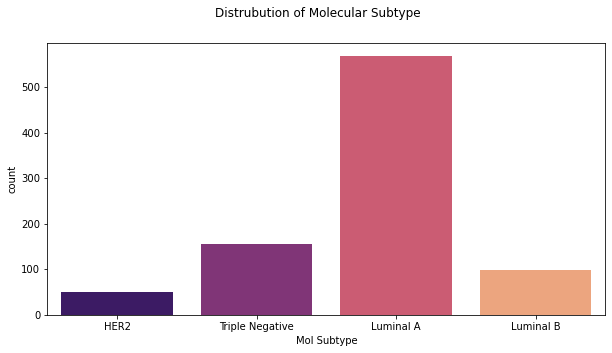

In [80]:
plt.figure(figsize=(10,5))
sns.countplot(x = "Mol Subtype",
        data = df_mol,
        #hue = "Recurrence event(s)",
        palette = 'magma'
        )
plt.suptitle("Distrubution of Molecular Subtype")

In [7]:
col_ohe = pd.get_dummies(df_mol["Mol Subtype"], prefix="Mol Subtype")
mol_data = pd.concat((df_mol, col_ohe), axis=1).drop("Mol Subtype", axis=1)

In [8]:
race_dict = {"0" : "NaN", 
             "1" : "White",
             "2" : "Black",
             "3" : "Asian",
             "4" : "Native",
             "5" : "Hispanic",
             "6" : "Multi",
             "7" : "Hawa",
             "8" : "American Indian"}
df_race = mol_data.replace({"Race and Ethnicity": race_dict})
df_race.head()

,Recurrence event(s),Date of Birth (Days),Menopause (at diagnosis),Race and Ethnicity,ER,PR,HER2,Tumor Grade Tubule,Tumor Grade Nuclear,Tumor Grade Mitotic,Staging(Tumor Size),Staging(Nodes),Mol Subtype_HER2,Mol Subtype_Luminal A,Mol Subtype_Luminal B,Mol Subtype_Triple Negative
1,0,-15209,0,Black,0,0,1,3,2,1,2.0,1.0,1,0,0,0
2,0,-14061,0,Black,0,0,0,3,3,3,2.0,0.0,0,0,0,1
3,0,-22685,1,White,1,1,0,3,2,1,2.0,1.0,0,1,0,0
4,0,-21479,1,White,1,1,0,3,2,1,1.0,0.0,0,1,0,0
5,0,-13932,0,Hispanic,1,0,1,3,3,3,2.0,1.0,0,0,1,0


<AxesSubplot:xlabel='Race and Ethnicity', ylabel='count'>

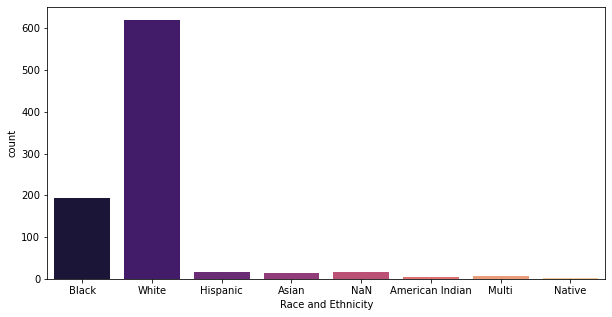

In [150]:
plt.figure(figsize=(10,5))
sns.countplot(x = "Race and Ethnicity",
        data = df_race,
        palette = 'magma'
        )

In [9]:
df_race = df_race[df_race['Race and Ethnicity'].str.contains('NaN') == False]

In [10]:
col_ohe = pd.get_dummies(df_race["Race and Ethnicity"], prefix="Race and Ethnicity")
full_data = pd.concat((df_race, col_ohe), axis=1).drop("Race and Ethnicity", axis=1)
full_data.head()

,Recurrence event(s),Date of Birth (Days),Menopause (at diagnosis),ER,PR,HER2,Tumor Grade Tubule,Tumor Grade Nuclear,Tumor Grade Mitotic,Staging(Tumor Size),...,Mol Subtype_Luminal A,Mol Subtype_Luminal B,Mol Subtype_Triple Negative,Race and Ethnicity_American Indian,Race and Ethnicity_Asian,Race and Ethnicity_Black,Race and Ethnicity_Hispanic,Race and Ethnicity_Multi,Race and Ethnicity_Native,Race and Ethnicity_White
1,0,-15209,0,0,0,1,3,2,1,2.0,...,0,0,0,0,0,1,0,0,0,0
2,0,-14061,0,0,0,0,3,3,3,2.0,...,0,0,1,0,0,1,0,0,0,0
3,0,-22685,1,1,1,0,3,2,1,2.0,...,1,0,0,0,0,0,0,0,0,1
4,0,-21479,1,1,1,0,3,2,1,1.0,...,1,0,0,0,0,0,0,0,0,1
5,0,-13932,0,1,0,1,3,3,3,2.0,...,0,1,0,0,0,0,1,0,0,0


In [11]:
full_data['Date of Birth (Days)'] = full_data['Date of Birth (Days)'].map(lambda x: x.lstrip('-'))

In [12]:
full_data = full_data.loc[full_data["Menopause (at diagnosis)"] != 2]

In [13]:
print(len(full_data))

857


In [156]:
#full_data.columns
full_data['Recurrence event(s)'].value_counts()

Index(['Recurrence event(s)', 'Date of Birth (Days)',
       'Menopause (at diagnosis)', 'ER', 'PR', 'HER2', 'Tumor Grade Tubule',
       'Tumor Grade Nuclear', 'Tumor Grade Mitotic', 'Staging(Tumor Size)',
       'Staging(Nodes)', 'Mol Subtype_HER2', 'Mol Subtype_Luminal A',
       'Mol Subtype_Luminal B', 'Mol Subtype_Triple Negative',
       'Race and Ethnicity_American Indian', 'Race and Ethnicity_Asian',
       'Race and Ethnicity_Black', 'Race and Ethnicity_Hispanic',
       'Race and Ethnicity_Multi', 'Race and Ethnicity_Native',
       'Race and Ethnicity_White'],
      dtype='object')

In [14]:
num_data = full_data.apply(pd.to_numeric)

# Brief Data Analysis

In [158]:
recurrence_df = num_data.loc[num_data['Recurrence event(s)'] == 1]

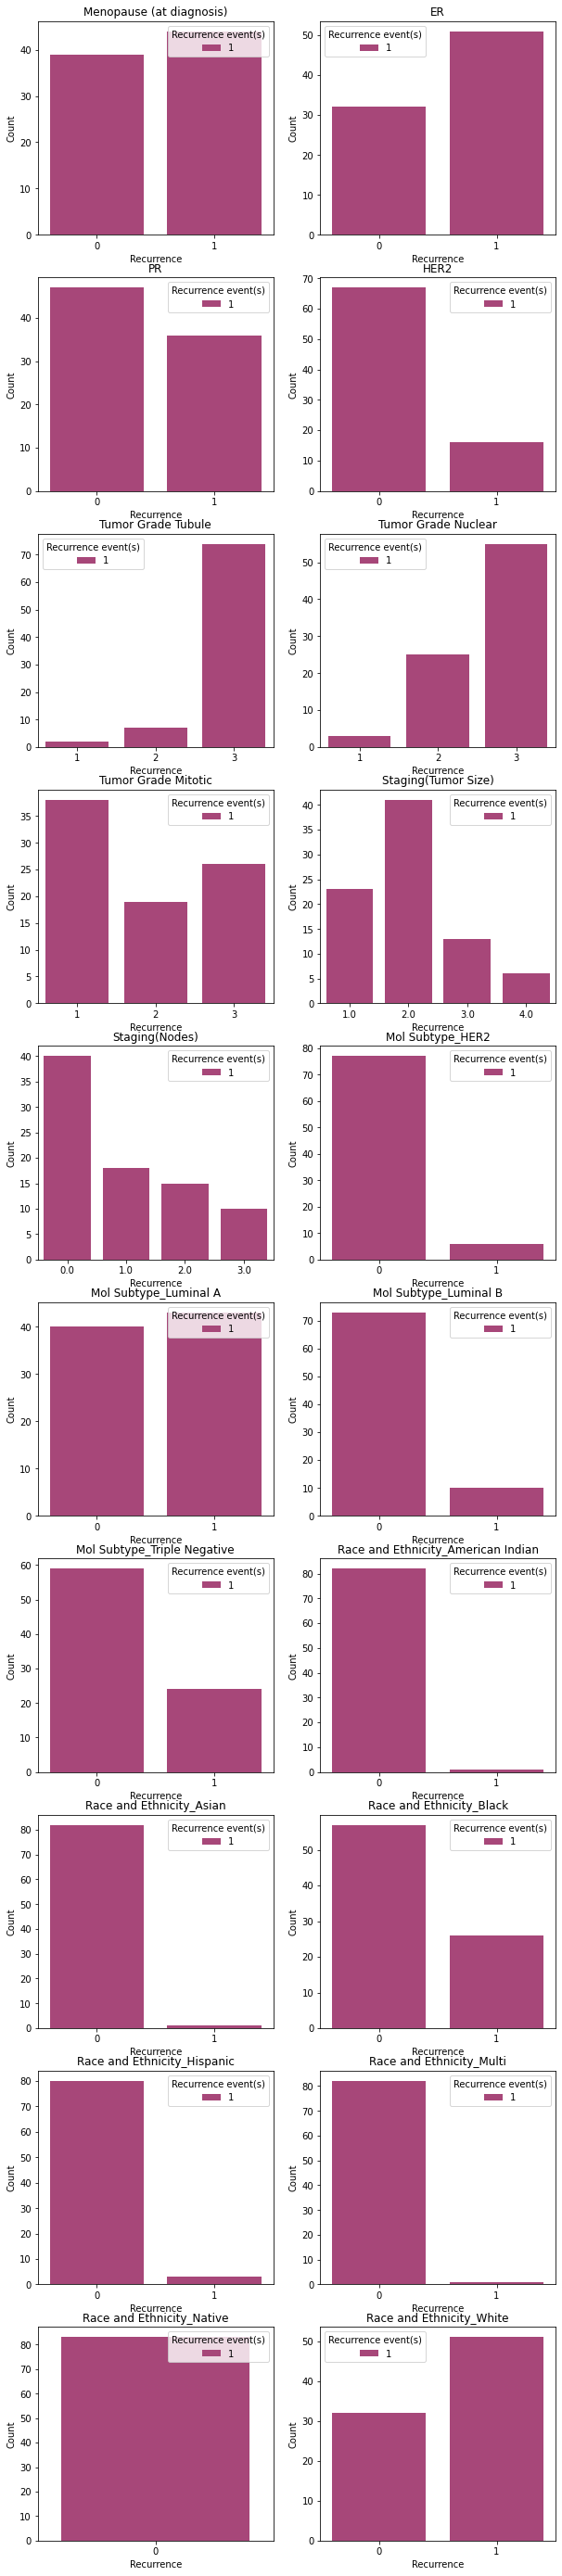

In [159]:
list_of_columns=recurrence_df.columns
#list_of_columns = ['Recurrence event(s)','Recurrence event(s)']

fig, ax = plt.subplots(10, 2, figsize = (10, 50))
ax = ax.flatten()

for i, column in enumerate(list_of_columns[2:]):
    sns.countplot(x = column, 
        ax=  ax[i],
        hue ='Recurrence event(s)',
        data = recurrence_df,
        palette = 'magma'
        )

    ax[i].set_title(column)
    ax[i].set_xlabel("Recurrence")
    ax[i].set_ylabel("Count")
    #ax[i].legend(loc='upper left', title = )

# Features of Importance (SHAP values)

In [17]:
y = num_data[['Recurrence event(s)']]
X = num_data.drop(['Recurrence event(s)'], axis = 1)

In [16]:
def heat_map(data):
    correlation = data.corr().round(2)
    plt.figure(figsize = (14,7))
    sns.heatmap(correlation, annot = True, cmap = 'YlOrBr')
    plt.show()
    
heat_map(num_data)

In [17]:
#common error with Shap make sure feature names are in a suitble format
#X.columns[X.columns.str.contains("[\[\]<,]")]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


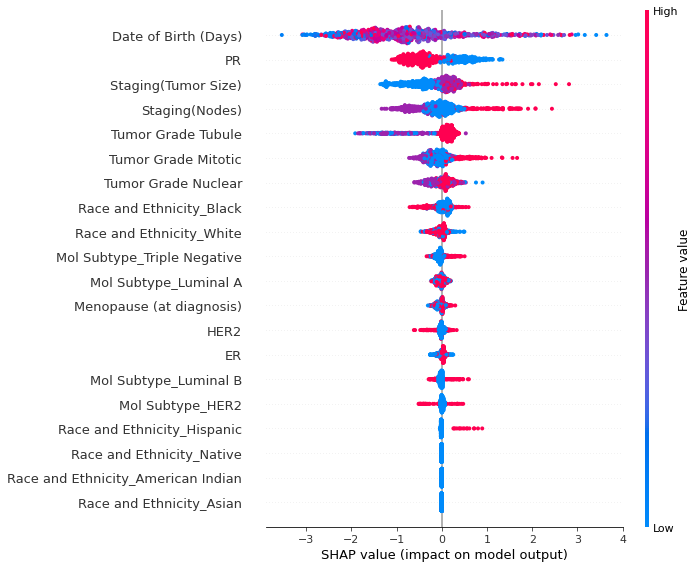

In [18]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X, y)
shap.initjs()

shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X)
shap.summary_plot(shap_values, X)

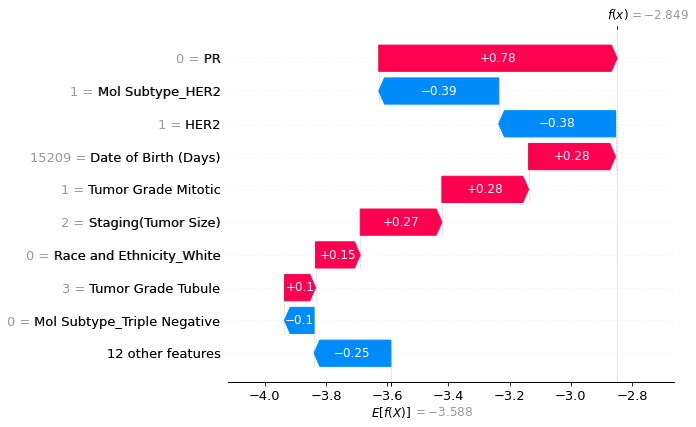

In [19]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


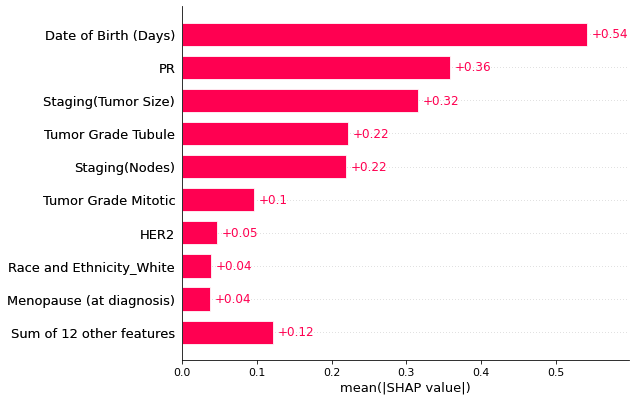

In [20]:
#train XGBoost model
model = XGBClassifier(n_estimators=100, max_depth=2).fit(X, y, eval_metric="logloss")
background_X = shap.maskers.Independent(X, max_samples=100)
# compute SHAP values
explainer = shap.Explainer(model, background_X)
shap_values = explainer(X)

shap.plots.bar(shap_values)

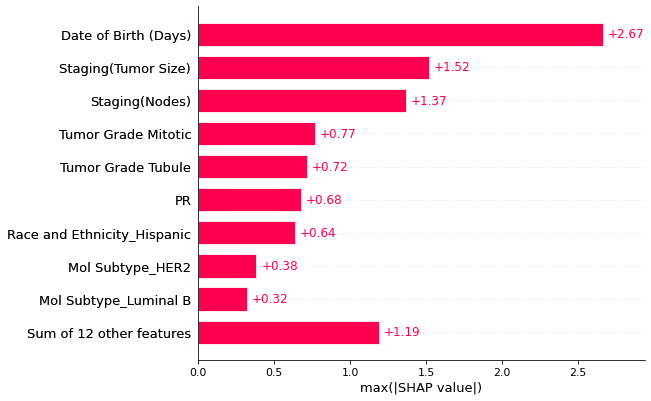

In [21]:
shap.plots.bar(shap_values.abs.max(0))

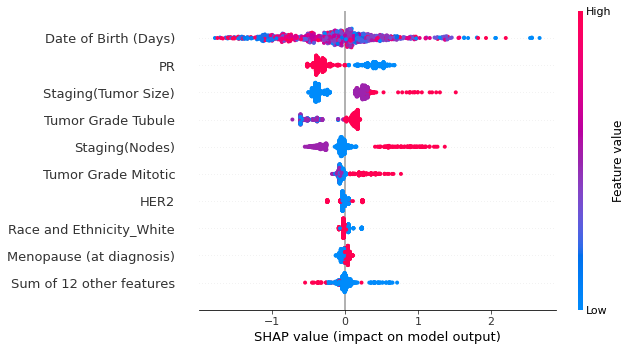

In [22]:
shap.plots.beeswarm(shap_values)

# Neural Network

## Test Train 
**After consideration of our data analysis and SHAP values a few different varriations of feature selected data were tried, below is the selection that provided the best results.**

In [15]:
data_smaller = num_data[['Recurrence event(s)',"Date of Birth (Days)", "Menopause (at diagnosis)", 
                         "Staging(Tumor Size)", "Staging(Nodes)", "PR", "HER2", 
                         "Tumor Grade Tubule","Tumor Grade Mitotic","Tumor Grade Nuclear", 'Mol Subtype_Triple Negative',
                         "Race and Ethnicity_Hispanic", "Race and Ethnicity_Asian"]]
data_smaller.head()

,Recurrence event(s),Date of Birth (Days),Menopause (at diagnosis),Staging(Tumor Size),Staging(Nodes),PR,HER2,Tumor Grade Tubule,Tumor Grade Mitotic,Tumor Grade Nuclear,Mol Subtype_Triple Negative,Race and Ethnicity_Hispanic,Race and Ethnicity_Asian
1,0,15209,0,2.0,1.0,0,1,3,1,2,0,0,0
2,0,14061,0,2.0,0.0,0,0,3,3,3,1,0,0
3,0,22685,1,2.0,1.0,1,0,3,1,2,0,0,0
4,0,21479,1,1.0,0.0,1,0,3,1,2,0,0,0
5,0,13932,0,2.0,1.0,0,1,3,3,3,0,1,0


In [16]:
def test_train_dataset(data, split_size, label):

    train_df, test_df = train_test_split(data, test_size=split_size, random_state=42)
    print(train_df.columns)
    
    # Form np arrays of labels and features.
    y_train = np.array(train_df.pop(label))
    y_test = np.array(test_df.pop(label))

    X_train = np.array(train_df)
    X_test = np.array(test_df)
    
    return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = test_train_dataset(data_smaller, 0.3, 'Recurrence event(s)')

Index(['Recurrence event(s)', 'Date of Birth (Days)',
       'Menopause (at diagnosis)', 'Staging(Tumor Size)', 'Staging(Nodes)',
       'PR', 'HER2', 'Tumor Grade Tubule', 'Tumor Grade Mitotic',
       'Tumor Grade Nuclear', 'Mol Subtype_Triple Negative',
       'Race and Ethnicity_Hispanic', 'Race and Ethnicity_Asian'],
      dtype='object')


In [18]:
scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Define the Model 

In [19]:
input_shape = X_train.shape[1]
print(input_shape)

12


In [20]:
img_input = Input(shape=(input_shape, ))

x = Dense(64, activation = "relu")(img_input)
x = Dense(128, activation = "relu")(x)
x = Dense(512, activation = "relu")(x)
x = Dropout(0.4)(x)
x = Dense(64, activation = "relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation = "sigmoid")(x)

model = Model(inputs = img_input, outputs = predictions)

In [66]:
"""tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)"""

'tf.keras.utils.plot_model(\n    model,\n    show_shapes=True,\n    show_layer_names=True,\n    rankdir="TB",\n    expand_nested=True,\n    dpi=96,\n)'

In [22]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.001),
              loss='binary_crossentropy',
              metrics= METRICS)

In [23]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "clinical_classification.h5", save_best_only=True
)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

## Rebalancing Class Weights

In [24]:
org_size = collections.Counter(y_train) 

n_classes= 2 
n_sample0= int(org_size.get(0))
n_sample1= int(org_size.get(1))
n_samples= n_sample0 + n_sample1
    

#Weights for class 0 (no reccurence):
w0=  n_samples/(n_classes*n_sample0) 

#Weights for class 1 (cancer recurence):
w1= n_samples/(n_classes*n_sample1)

class_weights = {0:w0*2, 1: w1*2}
print(org_size)
print(class_weights)

Counter({0: 544, 1: 55})
{0: 1.1011029411764706, 1: 10.89090909090909}


## Run the Model

In [25]:
BATCH_SIZE = 32

history = model.fit(X_train,
                    y_train,
                    batch_size= BATCH_SIZE,
                    validation_data = (X_test, y_test), 
                    class_weight =class_weights,
                    callbacks=[checkpoint_cb,early_stop ],
                    verbose = 2,
                    epochs=80)

Epoch 1/80
19/19 - 4s - loss: 1.3818 - tp: 21.0000 - fp: 104.0000 - tn: 440.0000 - fn: 34.0000 - accuracy: 0.7696 - precision: 0.1680 - recall: 0.3818 - auc: 0.5985 - prc: 0.1372 - val_loss: 0.6002 - val_tp: 12.0000 - val_fp: 57.0000 - val_tn: 173.0000 - val_fn: 16.0000 - val_accuracy: 0.7171 - val_precision: 0.1739 - val_recall: 0.4286 - val_auc: 0.6952 - val_prc: 0.1694 - 4s/epoch - 188ms/step
Epoch 2/80
19/19 - 0s - loss: 1.2557 - tp: 39.0000 - fp: 239.0000 - tn: 305.0000 - fn: 16.0000 - accuracy: 0.5743 - precision: 0.1403 - recall: 0.7091 - auc: 0.7040 - prc: 0.2090 - val_loss: 0.5852 - val_tp: 14.0000 - val_fp: 62.0000 - val_tn: 168.0000 - val_fn: 14.0000 - val_accuracy: 0.7054 - val_precision: 0.1842 - val_recall: 0.5000 - val_auc: 0.6693 - val_prc: 0.1668 - 197ms/epoch - 10ms/step
Epoch 3/80
19/19 - 0s - loss: 1.2466 - tp: 33.0000 - fp: 142.0000 - tn: 402.0000 - fn: 22.0000 - accuracy: 0.7262 - precision: 0.1886 - recall: 0.6000 - auc: 0.7147 - prc: 0.2304 - val_loss: 0.6510 - 

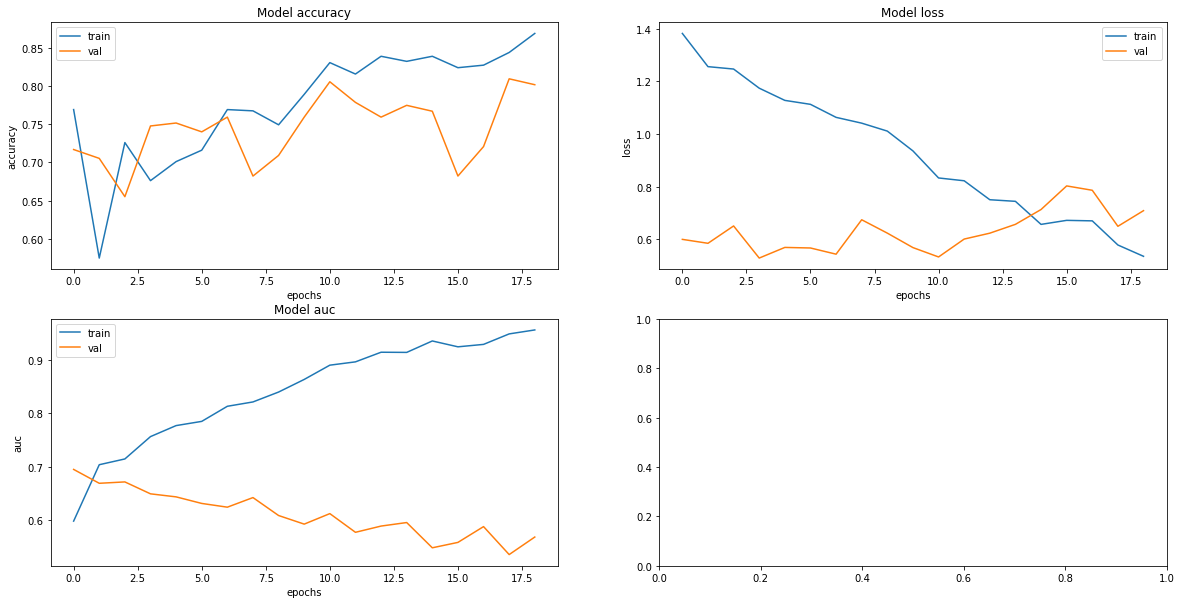

In [26]:
def plot_metrics(model_history, list_of_metrics):
    
    rows = int(np.ceil(len(list_of_metrics)/2))
    columns = 2
    
    fig, ax = plt.subplots(rows, columns, figsize=(20, 10))
    ax = ax.ravel()

    for i, metric in enumerate(list_of_metrics):
        ax[i].plot(model_history.history[metric])
        ax[i].plot(model_history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])

plot_metrics(history, ["accuracy", "loss", "auc"])

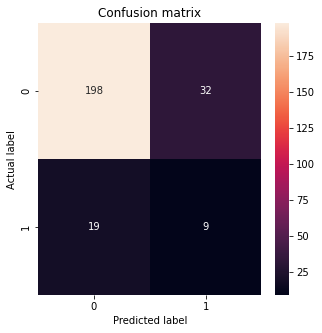

In [27]:
def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)
plot_cm(y_test, test_predictions_baseline)

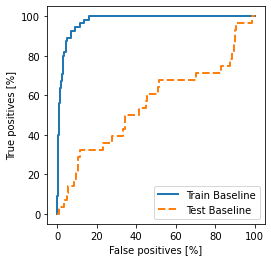

In [28]:
def plot_roc(name, labels, predictions, **kwargs):
      
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    ax = plt.gca()
    ax.set_aspect('equal')
        
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

plot_roc("Train Baseline", y_train, train_predictions_baseline)
plot_roc("Test Baseline", y_test, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right')

In [ ]:
def print_total_results(model, X_test, y_test):
    baseline_results = model.evaluate(X_test, y_test,
                                      batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
        print(name, ': ', value)

print_total_results(model, X_test, y_test)

In [ ]:
#model.load_weights("clinical_classification.h5")
prediction = model.predict(np.expand_dims(X_test[7], axis=0))[0]
print("Actual :", y_test[7])
scores = [1 - prediction[0], prediction[0]]

class_names = ["no reccurence", "reccurence"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan has %s"
        % ((100 * score), name)
    )

# Hyper Parameter tuner

In [210]:
LOG_DIR = "Hyperparameter_Tuning"
input_shape = X_train.shape[1]
img_input = Input(shape=(input_shape, ))
print(input_shape)

12


In [211]:
def model_builder(hp):
    
    img_input = Input(shape=(input_shape, ))

    hp_input_units = hp.Int('input_units', min_value=32, max_value=512, step=32)
    
    x = Dense((hp_input_units), activation = "relu")(img_input)
    
    for i in range(hp.Int("num_layers", min_value = 1, max_value = 4)):
        x = Dense(hp.Int(f'dense_{i}_units', min_value=32, max_value=512, 
                         step=32), activation = "relu")(x)
        x = Dropout(hp.Float(f"dropout_{i}", min_value =0, max_value =0.5, step = 0.1))(x)
        
    predictions = Dense(1, activation = "sigmoid")(x)

    model = Model(inputs = img_input, outputs = predictions)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate = hp_learning_rate),
              loss='binary_crossentropy',
              metrics= METRICS) 
    
    return model

**Tried both kers Hyperband and Bayesian Optimzer as hyperparameter tuners, using AUC as the objective due to the imabalanced nature of the dataset**

In [196]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('val_auc', direction='max'),
                     max_epochs = 30,
                     hyperband_iterations = 2,
                     directory = LOG_DIR,
                     project_name="trials_reccurence",
                     overwrite = True
                     )

In [212]:
tuner_bayes = kt.BayesianOptimization(
    model_builder,
    objective=kt.Objective('val_auc', direction='max'),
    overwrite=True,
    max_trials=100,
    directory = LOG_DIR,
    project_name="trials_reccurence_bayes"
    )

In [213]:
tuner_bayes.search(X_train,
             y_train,
             batch_size= BATCH_SIZE,
             validation_data = (X_test, y_test), 
             class_weight =class_weights,
             callbacks=[checkpoint_cb, early_stop],
             verbose = 1,
             epochs=20)

Trial 100 Complete [00h 00m 06s]
val_auc: 0.6849378347396851

Best val_auc So Far: 0.7486801147460938
Total elapsed time: 00h 16m 45s
INFO:tensorflow:Oracle triggered exit


In [198]:
best_hps=tuner_bayes.get_best_hyperparameters(1)[0]
print(best_hps.values)

{'input_units': 32, 'num_layers': 2, 'dense_0_units': 224, 'dropout_0': 0.2, 'learning_rate': 0.01, 'dense_1_units': 160, 'dropout_1': 0.30000000000000004, 'dense_2_units': 64, 'dropout_2': 0.0, 'dense_3_units': 160, 'dropout_3': 0.0}


In [214]:
bestHP = tuner_bayes.get_best_hyperparameters(num_trials=1)[0]

model = tuner_bayes.hypermodel.build(bestHP)

history = model.fit(X_train,
              y_train,
              batch_size= BATCH_SIZE,
              validation_data = (X_test, y_test), 
              class_weight =class_weights,
              callbacks=[early_stop],
              verbose = 1,
              epochs=80)

Epoch 1/80
19/19 [==============================] - 3s 59ms/step - loss: 1.4059 - tp: 57.0000 - fp: 468.0000 - tn: 306.0000 - fn: 26.0000 - accuracy: 0.4236 - precision: 0.1086 - recall: 0.6867 - auc: 0.5760 - prc: 0.1352 - val_loss: 0.8297 - val_tp: 22.0000 - val_fp: 166.0000 - val_tn: 64.0000 - val_fn: 6.0000 - val_accuracy: 0.3333 - val_precision: 0.1170 - val_recall: 0.7857 - val_auc: 0.5925 - val_prc: 0.1660
Epoch 2/80
19/19 [==============================] - 0s 5ms/step - loss: 1.3981 - tp: 42.0000 - fp: 388.0000 - tn: 156.0000 - fn: 13.0000 - accuracy: 0.3306 - precision: 0.0977 - recall: 0.7636 - auc: 0.5752 - prc: 0.1348 - val_loss: 0.8233 - val_tp: 22.0000 - val_fp: 166.0000 - val_tn: 64.0000 - val_fn: 6.0000 - val_accuracy: 0.3333 - val_precision: 0.1170 - val_recall: 0.7857 - val_auc: 0.5983 - val_prc: 0.1682
Epoch 3/80
19/19 [==============================] - 0s 4ms/step - loss: 1.3918 - tp: 42.0000 - fp: 389.0000 - tn: 155.0000 - fn: 13.0000 - accuracy: 0.3289 - precision

Epoch 21/80
19/19 [==============================] - 0s 5ms/step - loss: 1.3124 - tp: 41.0000 - fp: 298.0000 - tn: 246.0000 - fn: 14.0000 - accuracy: 0.4791 - precision: 0.1209 - recall: 0.7455 - auc: 0.6694 - prc: 0.1901 - val_loss: 0.7297 - val_tp: 20.0000 - val_fp: 125.0000 - val_tn: 105.0000 - val_fn: 8.0000 - val_accuracy: 0.4845 - val_precision: 0.1379 - val_recall: 0.7143 - val_auc: 0.6420 - val_prc: 0.1576
Epoch 22/80
19/19 [==============================] - 0s 5ms/step - loss: 1.3092 - tp: 41.0000 - fp: 298.0000 - tn: 246.0000 - fn: 14.0000 - accuracy: 0.4791 - precision: 0.1209 - recall: 0.7455 - auc: 0.6722 - prc: 0.1899 - val_loss: 0.7263 - val_tp: 20.0000 - val_fp: 122.0000 - val_tn: 108.0000 - val_fn: 8.0000 - val_accuracy: 0.4961 - val_precision: 0.1408 - val_recall: 0.7143 - val_auc: 0.6434 - val_prc: 0.1567
Epoch 23/80
19/19 [==============================] - 0s 5ms/step - loss: 1.3060 - tp: 41.0000 - fp: 295.0000 - tn: 249.0000 - fn: 14.0000 - accuracy: 0.4841 - preci

Epoch 41/80
19/19 [==============================] - 0s 4ms/step - loss: 1.2537 - tp: 43.0000 - fp: 250.0000 - tn: 294.0000 - fn: 12.0000 - accuracy: 0.5626 - precision: 0.1468 - recall: 0.7818 - auc: 0.7273 - prc: 0.2401 - val_loss: 0.6764 - val_tp: 17.0000 - val_fp: 88.0000 - val_tn: 142.0000 - val_fn: 11.0000 - val_accuracy: 0.6163 - val_precision: 0.1619 - val_recall: 0.6071 - val_auc: 0.6515 - val_prc: 0.1495
Epoch 42/80
19/19 [==============================] - 0s 4ms/step - loss: 1.2515 - tp: 43.0000 - fp: 245.0000 - tn: 299.0000 - fn: 12.0000 - accuracy: 0.5710 - precision: 0.1493 - recall: 0.7818 - auc: 0.7290 - prc: 0.2408 - val_loss: 0.6744 - val_tp: 17.0000 - val_fp: 87.0000 - val_tn: 143.0000 - val_fn: 11.0000 - val_accuracy: 0.6202 - val_precision: 0.1635 - val_recall: 0.6071 - val_auc: 0.6517 - val_prc: 0.1497
Epoch 43/80
19/19 [==============================] - 0s 6ms/step - loss: 1.2491 - tp: 43.0000 - fp: 240.0000 - tn: 304.0000 - fn: 12.0000 - accuracy: 0.5793 - preci

Epoch 61/80
19/19 [==============================] - 0s 5ms/step - loss: 1.2090 - tp: 41.0000 - fp: 210.0000 - tn: 334.0000 - fn: 14.0000 - accuracy: 0.6260 - precision: 0.1633 - recall: 0.7455 - auc: 0.7538 - prc: 0.2612 - val_loss: 0.6383 - val_tp: 15.0000 - val_fp: 72.0000 - val_tn: 158.0000 - val_fn: 13.0000 - val_accuracy: 0.6705 - val_precision: 0.1724 - val_recall: 0.5357 - val_auc: 0.6495 - val_prc: 0.1475
Epoch 62/80
19/19 [==============================] - 0s 6ms/step - loss: 1.2068 - tp: 41.0000 - fp: 208.0000 - tn: 336.0000 - fn: 14.0000 - accuracy: 0.6294 - precision: 0.1647 - recall: 0.7455 - auc: 0.7540 - prc: 0.2613 - val_loss: 0.6346 - val_tp: 15.0000 - val_fp: 72.0000 - val_tn: 158.0000 - val_fn: 13.0000 - val_accuracy: 0.6705 - val_precision: 0.1724 - val_recall: 0.5357 - val_auc: 0.6496 - val_prc: 0.1471
Epoch 63/80
19/19 [==============================] - 0s 6ms/step - loss: 1.2054 - tp: 41.0000 - fp: 207.0000 - tn: 337.0000 - fn: 14.0000 - accuracy: 0.6311 - preci

# Model Evaluation

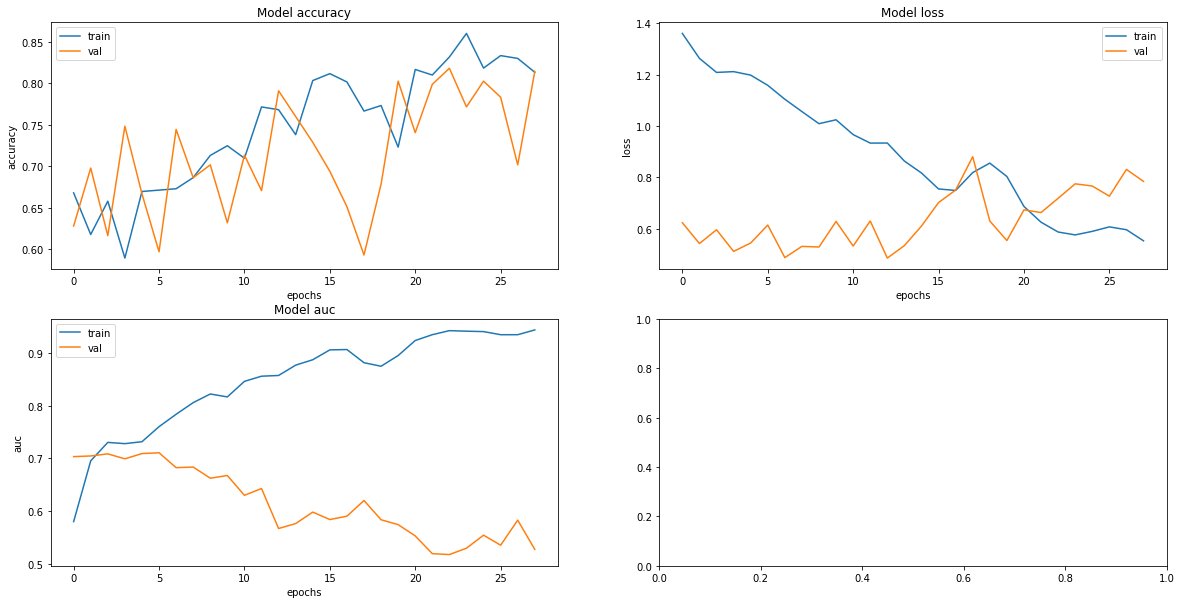

In [215]:
plot_metrics(history, ["accuracy", "loss", "auc"])

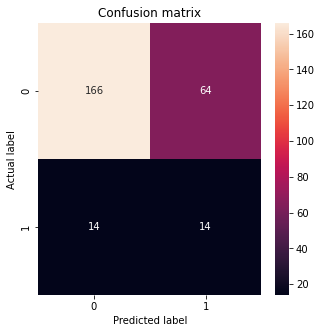

In [216]:
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)
plot_cm(y_test, test_predictions_baseline)

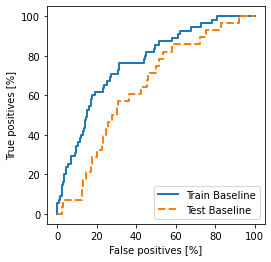

In [217]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

plot_roc("Train Baseline", y_train, train_predictions_baseline)
plot_roc("Test Baseline", y_test, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right')

In [218]:
print_total_results(model, X_test, y_test)

loss :  0.6103605031967163
tp :  14.0
fp :  64.0
tn :  166.0
fn :  14.0
accuracy :  0.6976743936538696
precision :  0.1794871836900711
recall :  0.5
auc :  0.6406832933425903
prc :  0.1450234353542328


In [219]:
#model.load_weights("clinical_classification.h5")
prediction = model.predict(np.expand_dims(X_test[7], axis=0))[0]
print("Actual :", y_test[7])
scores = [1 - prediction[0], prediction[0]]

class_names = ["no reccurence", "reccurence"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan has %s"
        % ((100 * score), name)
    )

Actual : 0
This model is 53.63 percent confident that MRI scan has no reccurence
This model is 46.37 percent confident that MRI scan has reccurence
